<a href="https://colab.research.google.com/github/sjdee/Market-Analysis-Techniques/blob/master/ExhaustiveFeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_id = '18pa4iuqvz2SX5RYrUdn09bDU8eNm2hqI'

# 2. Load a file by ID 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('sp500_transformation_input.xlsx')

In [0]:
import pandas as pd

df_all = pd.read_excel('sp500_transformation_input.xlsx')

In [0]:
# https://stackoverflow.com/questions/39187875/scikit-learn-script-giving-vastly-different-results-than-the-tutorial-and-gives
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# ['BEST_TARGET_PRICE','CUR_MKT_CAP', 'SHORT_INT', 'TOT_BUY_REC', 'TOT_SELL_REC', 'TOT_HOLD_REC','day10']
# f1 micro 0.8511608066796742
# f1 weighted 0.8510055463652249

# Added
# RETURN_ON_ASSET(+.3) 
# BEST_ANALYST_RATING / EQY_REC_CONS (+.15)  (pearson correlation of .76)

# Didnt add
# hold percent (+.2)
# TOT_ANALYST_REC(+.25)


df = df_all.loc[:,['BEST_ANALYST_RATING','RETURN_ON_ASSET', 'BEST_TARGET_PRICE','CUR_MKT_CAP', 'SHORT_INT', 'TOT_BUY_REC', 'TOT_SELL_REC', 'TOT_HOLD_REC','day10']]
df = df.dropna()

features = df.iloc[:,:-1]


X = features
# Scaling values in the feature set
scaling = MinMaxScaler(feature_range=(0,1)).fit(X)
X = scaling.transform(X)


y = df['day10']
y = y.astype(int)
y = y.replace(2,1)
y = y.to_numpy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)


clf = RandomForestClassifier(n_jobs=2, random_state=0, n_estimators =10)

print(type(X))
print(X.shape)

print(type(y))
print(y.shape)



<class 'numpy.ndarray'>
(420739, 8)
<class 'numpy.ndarray'>
(420739,)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
efs1 = EFS(clf, 
           min_features=1,
           max_features=8,
           scoring='accuracy',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(X_train, y_train, custom_feature_names = features.columns.values)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

Features: 255/255

Best accuracy score: 0.84
Best subset (indices): (0, 1, 2, 3, 4, 5, 6)
Best subset (corresponding names): ('BEST_ANALYST_RATING', 'RETURN_ON_ASSET', 'BEST_TARGET_PRICE', 'CUR_MKT_CAP', 'SHORT_INT', 'TOT_BUY_REC', 'TOT_SELL_REC')


In [0]:
# Generate the new subsets based on the selected features
# Note that the transform call is equivalent to
# X_train[:, efs1.k_feature_idx_]

X_train_efs = efs1.transform(X_train)
X_test_efs = efs1.transform(X_test)

# Fit the estimator using the new feature subset
# and make a prediction on the test data
clf.fit(X_train_efs, y_train)
y_pred = clf.predict(X_test_efs)

# Compute the accuracy of the prediction
acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
print('Test set accuracy: %.2f %%' % (acc*100))

Test set accuracy: 84.69 %


In [0]:
efs1.subsets_

{0: {'avg_score': 0.571196230536576,
  'cv_scores': array([0.57108176, 0.57108176, 0.57093866, 0.57238171, 0.57049726]),
  'feature_idx': (0,),
  'feature_names': ('BEST_ANALYST_RATING',)},
 1: {'avg_score': 0.6260962771904148,
  'cv_scores': array([0.62528861, 0.62963466, 0.62660645, 0.62487479, 0.62407687]),
  'feature_idx': (1,),
  'feature_names': ('RETURN_ON_ASSET',)},
 2: {'avg_score': 0.6664335256326884,
  'cv_scores': array([0.6646917 , 0.66550659, 0.6646181 , 0.669134  , 0.66821724]),
  'feature_idx': (2,),
  'feature_names': ('BEST_TARGET_PRICE',)},
 3: {'avg_score': 0.5318029121551258,
  'cv_scores': array([0.53329146, 0.53203518, 0.52742645, 0.53275724, 0.53350424]),
  'feature_idx': (3,),
  'feature_names': ('CUR_MKT_CAP',)},
 4: {'avg_score': 0.7458245209140215,
  'cv_scores': array([0.74724976, 0.74397324, 0.74802642, 0.74532706, 0.74454612]),
  'feature_idx': (4,),
  'feature_names': ('SHORT_INT',)},
 5: {'avg_score': 0.5672711569189379,
  'cv_scores': array([0.56780524

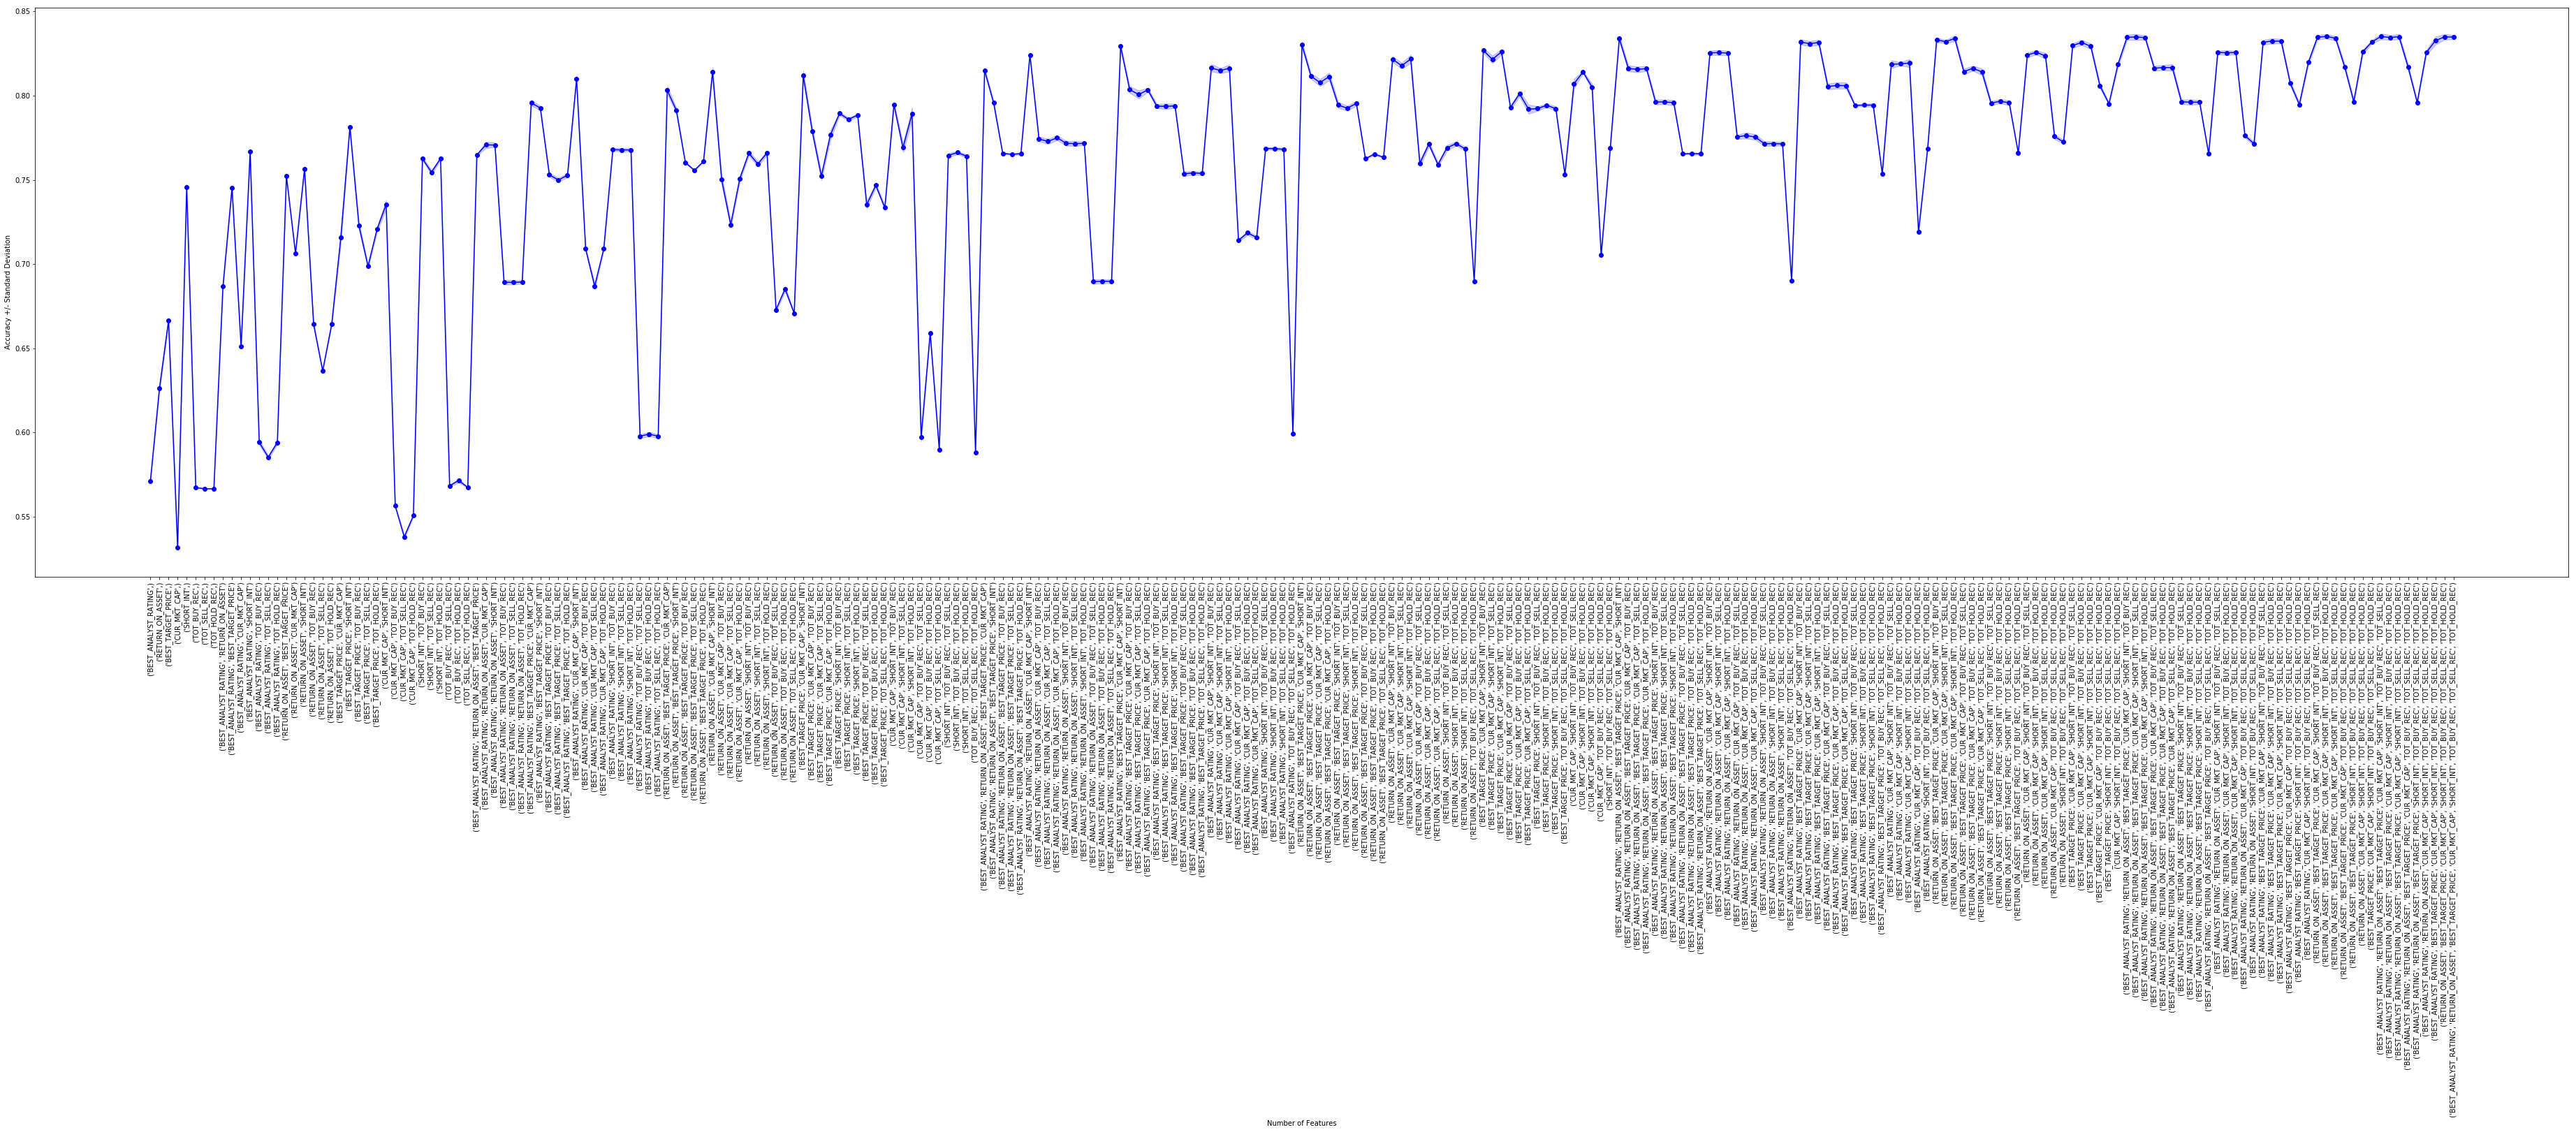

In [0]:
import matplotlib.pyplot as plt

metric_dict = efs1.get_metric_dict()

fig = plt.figure()
fig.set_size_inches(65, 15)
k_feat = sorted(metric_dict.keys())
avg = [metric_dict[k]['avg_score'] for k in k_feat]

upper, lower = [], []
for k in k_feat:
    upper.append(metric_dict[k]['avg_score'] +
                 metric_dict[k]['std_dev'])
    lower.append(metric_dict[k]['avg_score'] -
                 metric_dict[k]['std_dev'])

plt.fill_between(k_feat,
                 upper,
                 lower,
                 alpha=0.2,
                 color='blue',
                 lw=1)

plt.plot(k_feat, avg, color='blue', marker='o')
plt.ylabel('Accuracy +/- Standard Deviation')
plt.xlabel('Number of Features')
feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
plt.xticks(k_feat, 
           [str(metric_dict[k]['feature_names']) for k in k_feat], 
           rotation=90)
plt.show()